# Neural Networks in PyTorch
## Part 7b: A support vector classifier implemented as a neural network
*Yen Lee Loh, 2021-9-8, 2022-11-23*

---
## 1. Setup

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn        # import torch.nn as nn
import torchvision.datasets # In functional.py: patch PILLOW_VERSION--> __version__
import torchvision.transforms
#import time
from collections.abc import Iterable
rng = np.random.default_rng()
np.set_printoptions (linewidth=300)
#plt.rcParams.update ({'font.family':'monospace', 'font.size':11})
plt.rcParams.update ({'font.family':'serif', 'font.size':13})


def gallery(xnij, cmap='viridis', labels=None, size=1):  # size is in inches
  '''
  gallery(xnij)
  
      Display an array of grayscale images.
  '''
  nmax = len(xnij)
  cols = min(20,nmax) ; rows = (nmax+cols-1)//cols
  wspace = 0.02 ; hspace = 0.02
  if isinstance (labels, Iterable) or labels!=None:   # if user has supplied labels
    hspace = .35
    
  fig,axs = plt.subplots (rows,cols, figsize=(cols*size*(1+wspace),rows*size*(1+hspace)), gridspec_kw={'wspace':wspace,'hspace':hspace})
  if nmax==1: axs = np.array([[axs]])
  axs = axs.flatten()
  for ax in axs:
      ax.axis ('off')
  for n in range(nmax):
      ax = axs[n]
      if isinstance (cmap, Iterable) and not isinstance (cmap, str):
        c = cmap[n]
      else:
        c = cmap
      ax.imshow (xnij[n], cmap=c)
      ax.set_aspect('equal')
      if isinstance (labels, Iterable):
        ax.set_title (str(labels[n]))

def metrics (Yn, yn):
  '''
  totalExamples,misclassifiedExamples,confusionMatrix = metrics (modelOutputs, trueOutputs)
  
      This function accepts a set of model outputs (predictions) and a set of training outputs (labels).
      It returns various integers.  It's easiest to understand this by seeing an example.
  '''
  nmax = len(yn)
  ymax = max(yn)+1
  confmat = np.zeros ([ymax, ymax], dtype=int)   # confmat[Y][y]
  for n in range(nmax): confmat[yn[n], Yn[n]] += 1
  ntot = np.sum(confmat)
  nerr = ntot - np.trace(confmat)
  return ntot,nerr,confmat

def select (inputs, outputs, classes, nT, nV, shuffle=False):
  '''
  xT,yT,xV,yV = select (MNISTinputs, MNISToutputs, [5,6,8], [100,100,100], [200,200,200])

      Given a set of inputs and outputs, 
      construct a training set consisting of the first 100 5's, 100 6's, 100 8's, 
      and a validation set consisting of the next 200 5's, 200 6's, and 200 8's.
      If the original set has fewer than 300 5's, 6's, or 7's, raise an exception.
  '''
  assert len(classes) == len(nT) and len(nT) == len(nV)
  allT = []
  allV = []
  for k in range(len(classes)):
    indices, = np.where(outputs==classes[k])
    ntot = len(indices)
    indices = rng.choice (indices, nT[k] + nV[k], False)    # randomly choose 300
    indicesT,indicesV = np.split (indices, [nT[k]])
    allT += indicesT.tolist()
    allV += indicesV.tolist()
    print ('For class {}, given {} examples, we chose {} for training and {} for validation. '.format(classes[k], ntot, len(indicesT), len(indicesV)))
  if shuffle:
    rng.shuffle (allT)
    rng.shuffle (allV)
  return inputs[allT], outputs[allT], inputs[allV], outputs[allV]



def train(xnd, ynd, model, lossFunc, epochs=10000, learningRate=0.01, lossTarget=0.0001, reportInterval=1000):
  '''
  train (xnd, ynd, model, lossFunc, epochs=10000, learningRate=0.01, lossTarget=0.0001, reportInterval=1000)

      xnd      a torch.Tensor representing N training inputs (which are D-vectors)
      ynd      a torch.Tensor representing N training outputs (usually 1-vectors)
      model    a nn.Module that accepts a set of inputs and returns a set of outputs
      lossFunc a 
      and a validation set consisting of the next 200 5's, 200 6's, and 200 8's.
      If the original set has fewer than 300 5's, 6's, or 7's, raise an exception.
  '''
  optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
  model.train()                  # put model in training mode
  for t in range(epochs):      # t is the epoch number
    Ynd = model(xnd)             # uppercase Y = model prediction
    loss = lossFunc(Ynd,ynd)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if t % reportInterval == 0 or t==epochs:
      F = loss.item()
      print('Training epoch {}/{}  \t Loss = {:.4f}'.format(t, epochs, F))
      if F < lossTarget:
        print('Training epoch {}/{}  \t Loss = {:.4f} < lossTarget\n'.format(t, epochs, F))
        return
  print ('Warning: loss > lossTarget!\n')

In [90]:
#================ DOWNLOAD THE MNIST-TRAIN DATASET, WHICH CONTAINS 60000 HANDWRITTEN DIGITS
dataset = torchvision.datasets.MNIST('MNIST-TRAIN', download=True, train=True, transform=torchvision.transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=70000, shuffle=False)
iterator = iter(loader)
inputs,outputs = next(iterator)  # new PyTorch syntax; old syntax was iterator.next()
inputs = inputs.squeeze()        # get rid of unnecessary dimension

In [91]:
print ("torch.cuda.is_available() =", torch.cuda.is_available())

torch.cuda.is_available() = True


---
## 2. Load a digit pair from the MNIST dataset

In [127]:
class0,class1 = 6,9     #3,8     #1,5
xnijT,ynT,xnijV,ynV = select (inputs, outputs, [class0,class1], [2500,2500], [2500,2500], shuffle=True) 
xndT = xnijT.flatten (1,-1) ; yndT = (ynT.reshape (-1,1) - class0) / (class1-class0)
xndV = xnijV.flatten (1,-1) ; yndV = (ynV.reshape (-1,1) - class0) / (class1-class0)
_,imax,jmax = xnijT.shape
_,dmax = xndT.shape

For class 6, given 5918 examples, we chose 2500 for training and 2500 for validation. 
For class 9, given 5949 examples, we chose 2500 for training and 2500 for validation. 


---
## 3. Train SVC

We may implement a support vector classifier as a PyTorch neural network as follows.  
- Suppose we are given an input vector $\underline{\mathbf{x}}$ and an output label $y=\pm 1$.
- The linear predictor is $u = \underline{\mathbf{w}} \cdot \underline{\mathbf{x}} + b$.
- We will consider the output of the SVC to be $Y = u$.
- The decision function of the SVC is $Y_\text{mp} = \text{sgn} u$.
- The loss function is $F=\text{ReLU}(1-yY)$.

There are a couple of quirks to watch out for:
- When constructing the training outputs we have used the convention that $y\in \{0,1\}$.
- Therefore, in our implementation, the loss function should actually be $F=\text{ReLU} \big( 1-(2y-1)Y \big)$.
- To keep things general, we actually work with 1-dimensional tensors $\{y_d\}$ and $\{Y_d\}$.  We need to sum over the $d$ index to get a scalar.
  In other words, $F=\text{ReLU} \big( 1 -  \sum_{d=1}^1  (2y_d-1)Y_d \big)$.
- When operating on a batch of data, the loss function should be summed over data items as $F=\sum_n \text{ReLU} \big( 1-(2y_n-1)Y_n \big)$.
- Putting everything together, the loss function should be $F=\sum_n \text{ReLU} \big( 1- \sum_{d=1}^1 (2y_n-1)Y_n \big)$.
- The decision function should be $Y_\text{mp} = (\text{sgn} u + 1)/2$, so that $Y_\text{mp} \in \{0,1\}$.

We can implement the model and loss function very easily using PyTorch's building blocks:

In [128]:
#================ TRAIN SVC ON CPU
model    = nn.Linear(dmax,1)
lossFunc = lambda Ynd, ynd: nn.functional.relu (1 - torch.sum((2*ynd-1) * Ynd, axis=1) ).sum()
train (xndT, yndT, model, lossFunc, learningRate=0.1, reportInterval=1000)

Training epoch 0/10000  	 Loss = 5118.7090
Training epoch 1000/10000  	 Loss = 0.0000
Training epoch 1000/10000  	 Loss = 0.0000 < lossTarget



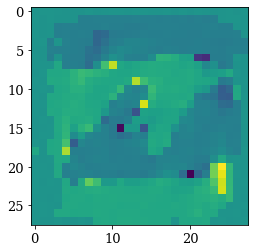

In [147]:
plt.imshow (model.weight.reshape (28,28).detach())

In [146]:
for n in range(10):
  Y = model (xndT[n:n+1])
  y = yndT[n:n+1]
  print ('Linear predictor u={:<+8.2f} Model prediction Y={:.0f}  Label y={:.0f}  Loss F={:<12.4}'.format(Y.item(), torch.sign(Y).item()/2+1/2, y.item(), lossFunc (Y, y)    ))

Linear predictor u=-9.56    Model prediction Y=0  Label y=0  Loss F=0.0         
Linear predictor u=+27.38   Model prediction Y=1  Label y=1  Loss F=0.0         
Linear predictor u=+22.99   Model prediction Y=1  Label y=1  Loss F=0.0         
Linear predictor u=+35.59   Model prediction Y=1  Label y=1  Loss F=0.0         
Linear predictor u=+24.26   Model prediction Y=1  Label y=1  Loss F=0.0         
Linear predictor u=+16.77   Model prediction Y=1  Label y=1  Loss F=0.0         
Linear predictor u=-30.23   Model prediction Y=0  Label y=0  Loss F=0.0         
Linear predictor u=-11.72   Model prediction Y=0  Label y=0  Loss F=0.0         
Linear predictor u=+12.20   Model prediction Y=1  Label y=1  Loss F=0.0         
Linear predictor u=-25.12   Model prediction Y=0  Label y=0  Loss F=0.0         


In [140]:
#================ EVALUATE ACCURACY FOR BOTH TRAINING AND VALIDATION SETS
model.eval()             # choose evaluation mode
YndT = model(xndT).sign()/2+1/2
YndV = model(xndV).sign()/2+1/2
YnT = YndT.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynT = yndT.detach().numpy().flatten().astype(int)          # this is already an integer
YnV = YndV.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynV = yndV.detach().numpy().flatten().astype(int)          # this is already an integer

ntot,nerr,Cnn = metrics (YnT, ynT)
print("Training error   = {:4d}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))
ntot,nerr,Cnn = metrics (YnV, ynV)
print("Validation error = {:4d}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))


Training error   =    0/5000 =  0.0%    Confusion matrix = [[2500, 0], [0, 2500]]
Validation error =   25/5000 =  0.5%    Confusion matrix = [[2491, 9], [16, 2484]]
